In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

In [14]:
dados = pd.read_csv('../dados/CSV_Completo.csv')

animal = 'É animal mais atropelado'
animalEscolhido = 'rã-manteiga'

dados.loc[dados.Animal == animalEscolhido,animal] = 1
dados.loc[dados.Animal != animalEscolhido,animal] = 0


dados[animal] = dados[animal].astype(int)

del(dados['Animal'])
del(dados['Km'])
del(dados['Hora da Coleta'])


Codificando os atributos

0    12915
1      181
Name: É animal mais atropelado, dtype: int64


<BarContainer object of 2 artists>

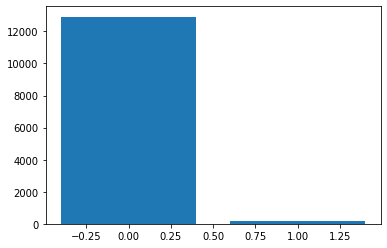

In [15]:
X = dados.iloc[:,:-1]
y = dados.iloc[:,-1]

import matplotlib.pyplot as plt

count = dados[animal].value_counts()
print(count)
plt.bar([0, 1], count) 

In [16]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
# Encoding the variable
X_encoded = X.apply(lambda x: d[x.name].fit_transform(x))


In [17]:
from sklearn.feature_selection import SelectKBest, chi2

features = []

for i in X_encoded:
    features.append(i)

k = 10 # seleciona 10 features

sel_chi2 = SelectKBest(chi2, k = 10)
X_train_novo = sel_chi2.fit_transform(X_encoded, y)

print("os atributos escolhidos foram:")
atributosSelect = []
for j in sel_chi2.get_support(indices=True):
    atributosSelect.append(features[j])
    
print(atributosSelect)

colums = ["target"]
col2 = []
for i in range(k):
    colums.append(i)
    col2.append(i)

print(X_train_novo.shape)

novoDf = pd.DataFrame(X_train_novo, y).reset_index()
novoDf.columns = [colums]

novoX = novoDf[col2]
novoY = novoDf["target"]

os atributos escolhidos foram:
['Mês', 'Estação', 'Trecho', 'Trecho macro', 'Tipo De Pistas', 'Numero de Pistas', 'Numero de Faixas', 'Velocidade Maxima', 'Local', 'Faixa de Quilometragem']
(13096, 10)


In [18]:
# Inverse the encoded
X_decoded = X_encoded.apply(lambda x: d[x.name].inverse_transform(x))
# print(X_decoded)
dados_filtrados = pd.DataFrame()

for i in atributosSelect:
    dados_filtrados[i] = X_decoded[i]
    
dados_filtrados[animal] = y

In [19]:
dadosEncod = pd.get_dummies(dados_filtrados)

# dadosEncod['target'] = y

dummies_names = []

x_codificado = dadosEncod

for i in x_codificado:
    dummies_names.append(i)
    # print(i)
    
dummies_names.remove(animal)

print(dummies_names)

['Mês', 'Trecho', 'Estação_Inverno', 'Estação_Outono', 'Estação_Primavera', 'Estação_Verão', 'Trecho macro_Baixada', 'Trecho macro_Planalto', 'Trecho macro_Serra', 'Tipo De Pistas_Barreira rígida (New Jersey)', 'Tipo De Pistas_Canteiro Central', 'Tipo De Pistas_Canteiro divisório', 'Tipo De Pistas_Canteiro divisório/Barreira de concreto', 'Tipo De Pistas_Canteiro divisório/defensa metálica', 'Tipo De Pistas_Defensa Metálica', 'Tipo De Pistas_Desconhecido', 'Tipo De Pistas_Sem divisão', 'Tipo De Pistas_defensa metálica/com muro', 'Numero de Pistas_0', 'Numero de Pistas_1', 'Numero de Pistas_2', 'Numero de Pistas_3', 'Numero de Pistas_4', 'Numero de Pistas_5', 'Numero de Pistas_6', 'Numero de Pistas_Desconhecido', 'Numero de Faixas_0', 'Numero de Faixas_1', 'Numero de Faixas_2', 'Numero de Faixas_3', 'Numero de Faixas_4', 'Numero de Faixas_5', 'Numero de Faixas_6', 'Numero de Faixas_7', 'Numero de Faixas_8', 'Numero de Faixas_9', 'Numero de Faixas_Desconhecido', 'Velocidade Maxima_0', 'V

<BarContainer object of 2 artists>

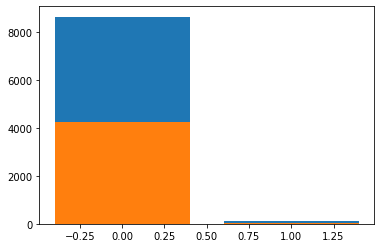

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

dadosTreino, dadosTeste = train_test_split(dadosEncod, test_size = 0.33, random_state = 0)

# countTreino = dadosTreino[animal].value_counts()
# countTeste = dadosTeste[animal].value_counts()

countTreino = dadosTreino[animal].value_counts()
countTeste = dadosTeste[animal].value_counts()
plt.bar([0, 1], countTreino) 
plt.bar([0, 1], countTeste) 



In [22]:
treino_y = dadosTreino.pop(animal)
treino_x = dadosTreino

teste_y = dadosTeste.pop(animal)
teste_x = dadosTeste


Balanceando

In [23]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(treino_x, treino_y)

In [24]:
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(max_depth=3)

# Creating adaboost classifier model
adb = AdaBoostClassifier(n_estimators=2, base_estimator=decisionTree, learning_rate=1.5, algorithm="SAMME")

adb_model = adb.fit(X_res,y_res)

y_predict = adb.predict(teste_x)
y_true = teste_y

score = adb_model.score(teste_x,teste_y)

print(score)

0.7082369273484498


              precision    recall  f1-score   support

           0       0.99      0.71      0.83      4270
           1       0.03      0.65      0.05        52

    accuracy                           0.71      4322
   macro avg       0.51      0.68      0.44      4322
weighted avg       0.98      0.71      0.82      4322

Matriz de confusão


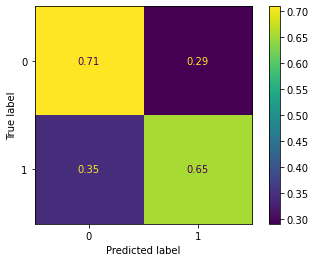

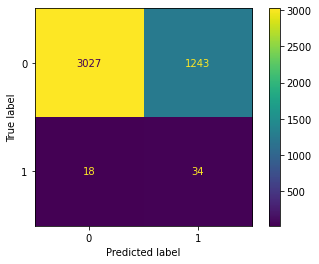

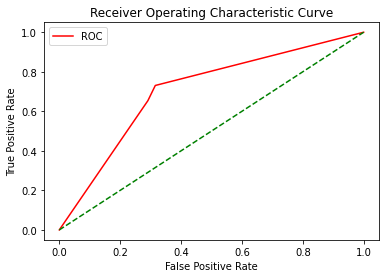

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(teste_y, y_predict, zero_division=0))

print("Matriz de confusão")
matriz_confusaoPorc = confusion_matrix(y_true, y_predict, normalize = 'true')
matrizPorc = ConfusionMatrixDisplay(matriz_confusaoPorc)
matrizPorc.plot()

matriz_confusao = confusion_matrix(y_true, y_predict)
matriz = ConfusionMatrixDisplay(matriz_confusao)
matriz.plot()
plt.show()

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
from sklearn.metrics import roc_curve

TargetVarScore = adb.predict_proba(teste_x)
fper, tper, thresholds = roc_curve(teste_y, TargetVarScore[:, 1])
plot_roc_curve(fper, tper)

In [32]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    for tree_idx, est in enumerate(tree.estimators_):
        tree_ = est.tree_
        feature_name = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in tree_.feature
        ]

        paths = []
        path = []
        
        def recurse(node, path, paths):
            
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_name[node]
                threshold = tree_.threshold[node]
                p1, p2 = list(path), list(path)
                p1 += [f"({name} <= {np.round(threshold, 3)})"]
                recurse(tree_.children_left[node], p1, paths)
                p2 += [f"({name} > {np.round(threshold, 3)})"]
                recurse(tree_.children_right[node], p2, paths)
            else:
                path += [(tree_.value[node], tree_.n_node_samples[node])]
                paths += [path]
                
        recurse(0, path, paths)

        # sort by samples count
        samples_count = [p[-1][1] for p in paths]
        ii = list(np.argsort(samples_count))
        paths = [paths[i] for i in reversed(ii)]
        
        rules = []
        for path in paths:
            rule = "Se "
            
            for p in path[:-1]:
                if rule != "Se ":
                    rule += " E "
                rule += str(p)
            rule += " então "
            if class_names is None:
                rule += "response: "+str(np.round(path[-1][0][0][0],3))
            else:
                classes = path[-1][0][0]
                l = np.argmax(classes)
                rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
            rule += f" | based on {path[-1][1]:,} samples"
            rules += [rule]
            
        return rules

In [33]:
false = "não é " + animalEscolhido
true = "é " + animalEscolhido

targets = {0: false, 1: true}

rules = get_rules(adb, dummies_names, targets)

# > 0.5 = true
# <= 0.5 = false

for r in rules:
    str(r)
    new_r = r.replace('> 0.5', "= true").replace('<= 0.5', "= false")
    print(new_r)

Se (Estação_Primavera = true) E (Numero de Pistas_1 = false) E (Velocidade Maxima_90 = false) então class: é rã-manteiga (proba: 79.98%) | based on 6,778 samples
Se (Estação_Primavera = false) E (Mês > 2.5) E (Mês <= 8.5) então class: não é rã-manteiga (proba: 94.93%) | based on 4,201 samples
Se (Estação_Primavera = false) E (Mês <= 2.5) E (Local_Pista de rolamento = false) então class: é rã-manteiga (proba: 65.64%) | based on 3,623 samples
Se (Estação_Primavera = false) E (Mês > 2.5) E (Mês > 8.5) então class: não é rã-manteiga (proba: 62.98%) | based on 1,094 samples
Se (Estação_Primavera = true) E (Numero de Pistas_1 = false) E (Velocidade Maxima_90 = true) então class: não é rã-manteiga (proba: 71.2%) | based on 566 samples
Se (Estação_Primavera = true) E (Numero de Pistas_1 = true) E (Trecho > 3.5) então class: não é rã-manteiga (proba: 100.0%) | based on 513 samples
Se (Estação_Primavera = false) E (Mês <= 2.5) E (Local_Pista de rolamento = true) então class: não é rã-manteiga (p